In [1]:
import numpy as np
import realization as rn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
kout, stats, hists = rn.ng.driver(dims=(1024,1024), fNL=0, Pk=1, eq_vol=True, ng_pow=6)

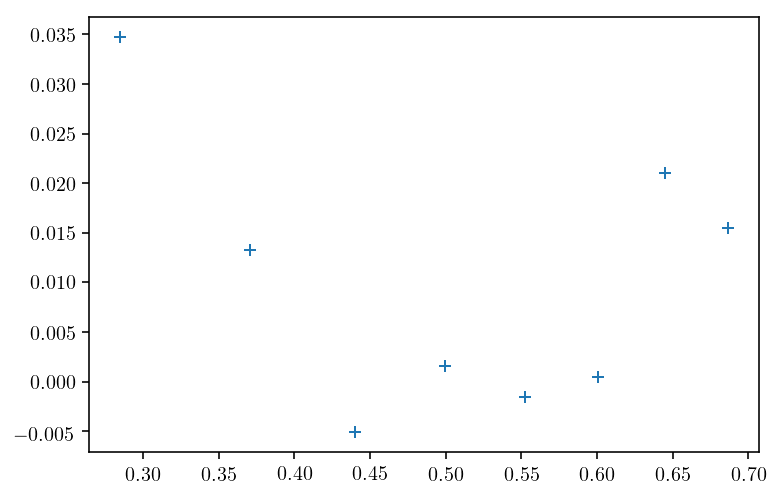

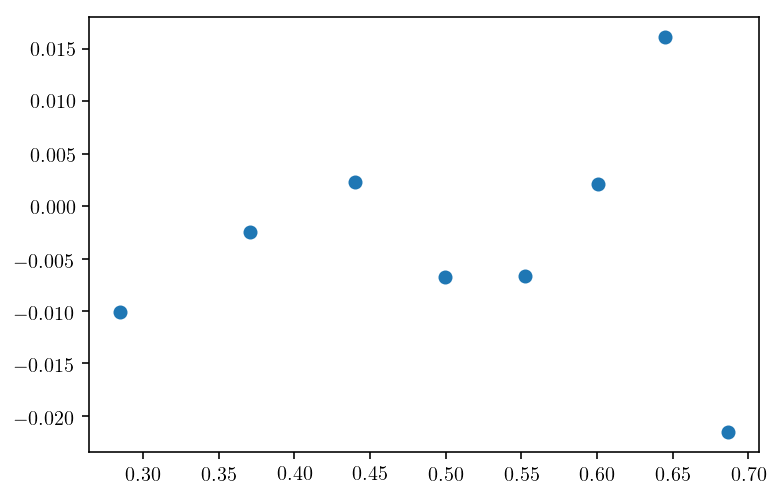

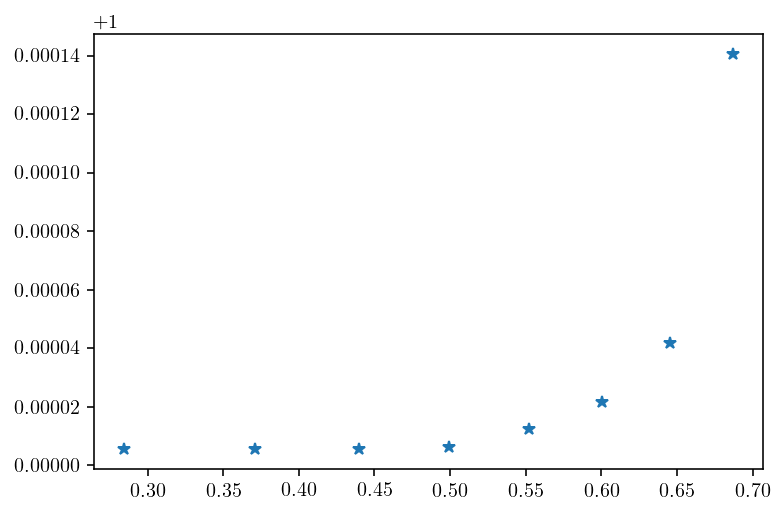

In [3]:
plt.figure()
i1 = 1
plt.plot(kout[i1:], stats.T[3][i1:], '+')
plt.figure()
plt.plot(kout[i1:], stats.T[2][i1:], 'o')
plt.figure()
plt.plot(kout[i1:], stats.T[1][i1:], '*')

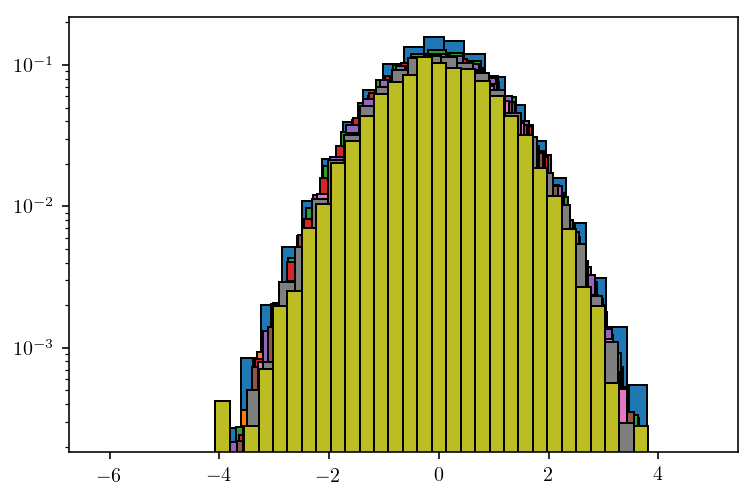

In [ ]:
## see http://stackoverflow.com/questions/44003552/matplotlib-histogram-from-numpy-histogram-output
for frq, edges in hists[0:]:
    frq = np.array(frq,dtype=np.float)
    frq /= frq.sum()
    plt.bar(edges[:-1], frq, width=np.diff(edges), ec="k", align="edge", log=True)
    # plt.figure()
    
plt.figure()
for frq, edges in hists[0:]:
    frq = np.array(frq,dtype=np.float)
    frq /= frq.sum()
    ctrs = edges[:-1] + np.diff(edges)
    plt.semilogy(ctrs, frq)
    # plt.figure()

In [8]:
plt.bar?